<a href="https://colab.research.google.com/github/kdh1647/Bumblebee2/blob/master/DRB_PO_LSTM_WeekForecasting2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Embedding

In [2]:
tf.config.list_physical_devices('GPU')

[]

### Data Read

In [3]:
raw_df = pd.read_csv('https://raw.githubusercontent.com/kdh1647/Bumblebee2/master/B72W2_3MA_5MA_PS.csv')

In [6]:
raw_df.head

<bound method NDFrame.head of       OrderDate  YYYYWEEK  OrderQty     3MA    5MA     PS
0    2013-01-07    201302       262  243.01  227.0  472.5
1    2013-01-14    201303       411  426.67  411.2  567.0
2    2013-01-21    201304       373  349.66  360.4  472.5
3    2013-01-28    201305       272  306.00  338.2  570.6
4    2013-02-04    201306       525  484.33  354.4  385.2
..          ...       ...       ...     ...    ...    ...
504  2022-08-29    202235       257  429.66  597.2  394.6
505  2022-09-05    202236       223  298.67  295.6  392.0
506  2022-09-13    202237       415  360.01  317.6  490.0
507  2022-09-19    202238       656  610.67  573.4  490.0
508  2022-09-26    202239       248  343.33  439.6  490.0

[509 rows x 6 columns]>

In [7]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509 entries, 0 to 508
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   OrderDate  509 non-null    object 
 1   YYYYWEEK   509 non-null    int64  
 2   OrderQty   509 non-null    int64  
 3   3MA        509 non-null    float64
 4   5MA        509 non-null    float64
 5   PS         509 non-null    float64
dtypes: float64(3), int64(2), object(1)
memory usage: 24.0+ KB


In [8]:
data = raw_df[['YYYYWEEK', 'OrderQty']]
data

,YYYYWEEK,OrderQty
0,201302,262
1,201303,411
2,201304,373
3,201305,272
4,201306,525
...,...,...
504,202235,257
505,202236,223
506,202237,415
507,202238,656


In [9]:
import datetime

In [10]:
import numpy as np

def MAPE_Val(y_pred, y_true):    
    return np.mean(np.abs((y_true - y_pred) / y_true)) 

In [11]:
raw_df.OrderDate = pd.to_datetime(raw_df['OrderDate'], format='%Y-%m-%d')    #주단위 집계일중 첫번째 일자

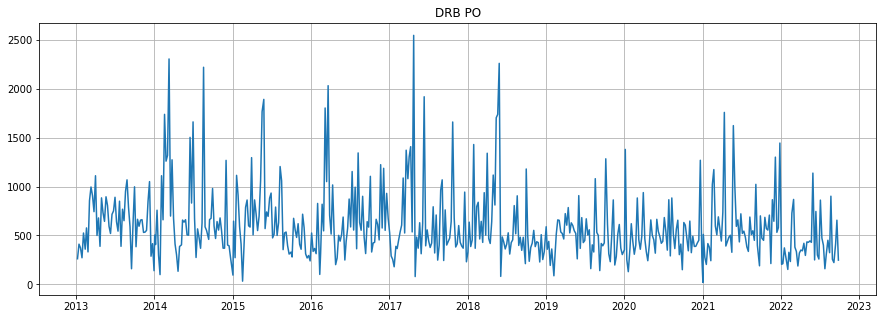

In [12]:
plt.figure(figsize=(15, 5)) 
plt.title('DRB PO')
plt.grid()

plt.plot(raw_df['OrderDate'], raw_df['OrderQty'])
plt.show()

### Data Preprocessing

In [13]:
raw_df.describe()

,YYYYWEEK,OrderQty,3MA,5MA,PS
count,509.000000,509.000000,509.000000,509.000000,509.000000
mean,201765.424361,600.524558,600.485187,600.505305,496.766601
std,281.851794,362.254035,357.365509,332.379252,97.821199
min,201301.000000,20.000000,34.000000,60.000000,77.500000
25%,201524.000000,377.000000,378.000000,386.600000,467.500000
50%,201747.000000,513.000000,510.340000,530.200000,498.000000
75%,202018.000000,690.000000,698.340000,700.400000,575.400000
max,202239.000000,2544.000000,2628.670000,2445.000000,714.500000


### 결측치 제거

In [14]:
raw_df.isnull().sum()

OrderDate    0
YYYYWEEK     0
OrderQty     0
3MA          0
5MA          0
PS           0
dtype: int64

In [15]:
#컬럼에 0의 개수 확인
for col in raw_df.columns:
    missing_rows = raw_df.loc[raw_df[col]==0].shape[0]
    print(col + ':' + str(missing_rows))

OrderDate:0
YYYYWEEK:0
OrderQty:0
3MA:0
5MA:0
PS:0


In [16]:
raw_df.loc[raw_df['5MA'].isna()]

,OrderDate,YYYYWEEK,OrderQty,3MA,5MA,PS


In [17]:
#missing data 처리
raw_df = raw_df.dropna()
raw_df.isnull().sum()

OrderDate    0
YYYYWEEK     0
OrderQty     0
3MA          0
5MA          0
PS           0
dtype: int64

### 정규화

In [18]:
from sklearn.preprocessing import MinMaxScaler

In [19]:
scaler = MinMaxScaler()
scale_col = ['OrderQty', '3MA', '5MA', 'PS']

In [20]:
scaled_df = scaler.fit_transform(raw_df[scale_col])
scaled_df

array([[0.09587956, 0.0805536 , 0.07002096, 0.62009419],
       [0.15491284, 0.15133716, 0.14725367, 0.76844584],
       [0.13985737, 0.12165709, 0.12595388, 0.62009419],
       ...,
       [0.15649762, 0.12564604, 0.10800839, 0.64756672],
       [0.25198098, 0.22225177, 0.21526205, 0.64756672],
       [0.09033281, 0.11921747, 0.15916143, 0.64756672]])

In [21]:
# scaled_df = pd.DataFrame(scaled_df, columns=scale_col)    #ndarray array -> DataFrame
scaled_df = pd.DataFrame(scaled_df, columns=scale_col)

In [22]:
scaled_df['OrderDate'] = raw_df['OrderDate']    #정규화 이 후 날짜 추가

In [23]:
scaled_df

,OrderQty,3MA,5MA,PS,OrderDate
0,0.095880,0.080554,0.070021,0.620094,2013-01-07
1,0.154913,0.151337,0.147254,0.768446,2013-01-14
2,0.139857,0.121657,0.125954,0.620094,2013-01-21
3,0.099842,0.104830,0.116646,0.774097,2013-01-28
4,0.200079,0.173560,0.123438,0.483046,2013-02-04
...,...,...,...,...,...
504,0.093899,0.152490,0.225241,0.497802,2022-08-29
505,0.080428,0.102005,0.098784,0.493721,2022-09-05
506,0.156498,0.125646,0.108008,0.647567,2022-09-13
507,0.251981,0.222252,0.215262,0.647567,2022-09-19


In [24]:
scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509 entries, 0 to 508
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   OrderQty   509 non-null    float64       
 1   3MA        509 non-null    float64       
 2   5MA        509 non-null    float64       
 3   PS         509 non-null    float64       
 4   OrderDate  509 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(4)
memory usage: 20.0 KB


In [25]:
scaled_df.query("OrderQty == 0.0 ")

,OrderQty,3MA,5MA,PS,OrderDate
417,0.0,0.0,0.0,0.023862,2021-01-02


In [26]:
scaled_df = scaled_df.drop(417)    #정규화 이 후 결측 데이터 제거

In [27]:
scaled_df.query("OrderQty == 0.0 ")

,OrderQty,3MA,5MA,PS,OrderDate


### 수요예측을 위해 3MA, 5MA, ORDERQTY항목을 feature 선정
  - 정답은 ORDERQTY 선정
  - 시계열 데이터를 위한 windows size = 20

In [28]:
# 입력 파라미터 feature, label => numpy type
# 윈도우 크기 만큼 DATASET 생성
def make_sequence_dataset(feature, label, window_size):
    feature_list = []    #생성될 feature list
    label_list = []      #생설될 label list
    
    for i in range(len(feature)-windows_size):
        feature_list.append(feature[i:i+window_size])
        label_list.append(label[i+window_size])
    
    return np.array(feature_list), np.array(label_list)

In [29]:
# feature_df, lablel_df 생성
# feature_cols = ['OrderQty', '3MA', '5MA', 'PS']
# feature_cols = ['OrderQty','5MA', 'PS']
feature_cols = ['OrderQty', '3MA', 'PS']
label_cols = ['OrderQty']

feature_df = pd.DataFrame(scaled_df, columns=feature_cols)
label_df = pd.DataFrame(scaled_df, columns=label_cols)

In [31]:
# Dataframe -> numpy 변환
feature_np = feature_df.to_numpy()
label_np = label_df.to_numpy()

print(feature_np.shape, label_np.shape)

(508, 3) (508, 1)


### 시계열 DATASET 생성 (make_sequence_dataset)

In [32]:
windows_size = 12
X, Y = make_sequence_dataset(feature_np, label_np, windows_size)

In [33]:
print(X.shape, Y.shape)

(496, 12, 3) (496, 1)


### 학습데이터, 테스트데이터 생성

In [34]:
#train, test 분리 20%
split = -round(len(X) * 0.2)

x_train = X[0:split]
y_train = Y[0:split]

x_test = X[split:]
y_test = Y[split:]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(397, 12, 3) (397, 1)
(99, 12, 3) (99, 1)


In [35]:
x_train[0].shape

(12, 3)

### LSTM Model and Compile

In [36]:
#모델생성
model = Sequential()
# model.add(LSTM(128, activation='tanh', input_shape=x_train[0].shape))
model.add(LSTM(128, return_sequences=True, input_shape=x_train[0].shape))
model.add(Dropout(0.2))
# model.add(LSTM(50, return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 128)           67584     
                                                                 
 dropout (Dropout)           (None, 12, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                35800     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 103,435
Trainable params: 103,435
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.compile(loss='mse', optimizer='adam', metrics=['mae', 'acc'])

### 모델학습 (Early Stop)

In [39]:
from tensorflow.keras.callbacks import EarlyStopping

In [40]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [42]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=10, callbacks=[early_stop])
# model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=40)

Epoch 1/50
40/40 [==============================] - 2s 47ms/step - loss: 0.0235 - mae: 0.1086 - acc: 0.0000e+00 - val_loss: 0.0161 - val_mae: 0.1027 - val_acc: 0.0000e+00
Epoch 2/50
40/40 [==============================] - 1s 27ms/step - loss: 0.0225 - mae: 0.1039 - acc: 0.0000e+00 - val_loss: 0.0179 - val_mae: 0.1130 - val_acc: 0.0000e+00
Epoch 3/50
40/40 [==============================] - 1s 24ms/step - loss: 0.0219 - mae: 0.1059 - acc: 0.0000e+00 - val_loss: 0.0148 - val_mae: 0.0860 - val_acc: 0.0000e+00
Epoch 4/50
40/40 [==============================] - 1s 24ms/step - loss: 0.0229 - mae: 0.1069 - acc: 0.0000e+00 - val_loss: 0.0149 - val_mae: 0.0838 - val_acc: 0.0000e+00
Epoch 5/50
40/40 [==============================] - 1s 22ms/step - loss: 0.0245 - mae: 0.1114 - acc: 0.0000e+00 - val_loss: 0.0161 - val_mae: 0.1032 - val_acc: 0.0000e+00
Epoch 6/50
40/40 [==============================] - 1s 22ms/step - loss: 0.0221 - mae: 0.1029 - acc: 0.0000e+00 - val_loss: 0.0154 - val_mae: 0.0

### 예측을 통한 정답과 비교 (오차계산 MAPE, 평균절대값 백분율오차)

![image.png](attachment:image.png)

In [43]:
pred = model.predict(x_test)

4/4 [==============================] - 1s 10ms/step


In [44]:
x_value = scaled_df.iloc[split:, 4:5].copy()    #그래프에 날짜 표기를 위한 X값

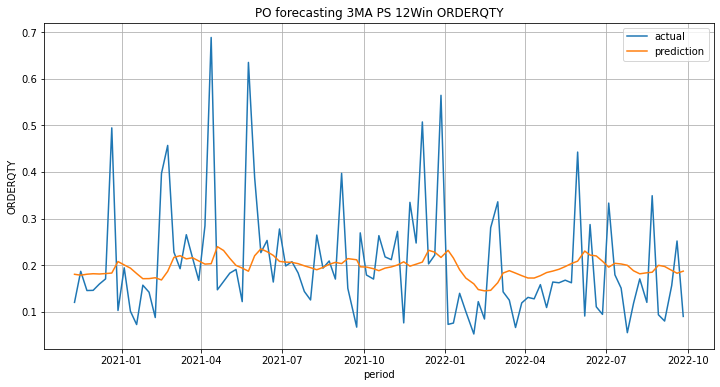

In [45]:
plt.figure(figsize=(12,6))
plt.title('PO forecasting 3MA PS 12Win ORDERQTY')
plt.ylabel('ORDERQTY')
plt.xlabel('period')
plt.plot(x_value.OrderDate, y_test, label='actual')
plt.plot(x_value.OrderDate, pred, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()

In [46]:
# MAPE
# print(np.sum(abs(y_test-pred)/y_test)/len(x_test))
MAPE_Val(pred, y_test)

0.5121680917417445